In [12]:
BASE_DIR = r"C:\Users\lenov\image_quality_assesment\archive"
print(BASE_DIR)
print(os.path.exists(BASE_DIR))

C:\Users\lenov\image_quality_assesment\archive
True


In [13]:
IMG_DIR = os.path.join(BASE_DIR, "512x384")
print(os.path.exists(IMG_DIR))
print(os.listdir(IMG_DIR)[:5])

True
['10004473376.jpg', '10007357496.jpg', '10007903636.jpg', '10009096245.jpg', '100117038.jpg']


In [14]:
import pandas as pd
import os

SCORES_CSV = os.path.join(BASE_DIR, "koniq10k_scores_and_distributions.csv")

scores_df = pd.read_csv(SCORES_CSV)
scores_df = scores_df[["image_name", "MOS"]].dropna().reset_index(drop=True)
scores_df["image_name"] = scores_df["image_name"].astype(str).str.strip()
scores_df["MOS"] = scores_df["MOS"].astype(float)

print(scores_df.shape)
scores_df.head()


(10073, 2)


,image_name,MOS
0,10004473376.jpg,3.828571
1,10007357496.jpg,3.479167
2,10007903636.jpg,3.781250
3,10009096245.jpg,3.926606
4,100117038.jpg,3.830000


In [15]:
import numpy as np
import cv2

def blockiness(gray):
    h, w = gray.shape
    if h < 9 or w < 9:
        return 0.0
    vb = [np.mean(np.abs(gray[:, x] - gray[:, x-1])) for x in range(8, w, 8)]
    hb = [np.mean(np.abs(gray[y, :] - gray[y-1, :])) for y in range(8, h, 8)]
    if (len(vb) + len(hb)) == 0:
        return 0.0
    return float(np.mean(vb + hb))

def extract_features(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        return None

    img = cv2.resize(img, (512, 384))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    smooth = cv2.GaussianBlur(gray, (0, 0), 1)
    noise = float(np.std(gray.astype(np.float32) - smooth.astype(np.float32)))

    brightness = float(np.mean(gray))
    contrast   = float(np.std(gray))

    edges = cv2.Canny(gray, 100, 200)
    edge_density = float(np.mean(edges > 0))

    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    p = hist / (hist.sum() + 1e-8)
    entropy = float(-np.sum(p * np.log2(p + 1e-12)))

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, 3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, 3)
    grad = np.sqrt(gx*gx + gy*gy)
    grad_mean = float(np.mean(grad))
    grad_std  = float(np.std(grad))

    blk = blockiness(gray)

    return [blur, noise, brightness, contrast, edge_density, entropy, grad_mean, grad_std, blk]


In [16]:
from tqdm import tqdm
import os

cols = ["image_name","MOS",
        "blur","noise","brightness","contrast",
        "edge_density","entropy","grad_mean","grad_std","blockiness"]

rows = []
missing = 0
read_fail = 0

for _, r in tqdm(scores_df.head(200).iterrows(), total=200):
    img_name = r["image_name"]
    img_path = os.path.join(IMG_DIR, img_name)

    if not os.path.exists(img_path):
        missing += 1
        continue

    f = extract_features(img_path)
    if f is None:
        read_fail += 1
        continue

    rows.append([img_name, r["MOS"]] + f)

features_df = pd.DataFrame(rows, columns=cols)
print("missing:", missing, "read_fail:", read_fail)
print("features_df:", features_df.shape)
features_df.head()


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 90.86it/s]

missing: 0 read_fail: 0
features_df: (200, 11)


,image_name,MOS,blur,noise,brightness,contrast,edge_density,entropy,grad_mean,grad_std,blockiness
0,10004473376.jpg,3.828571,5882.530945,18.882174,99.917567,72.924066,0.215993,7.810043,123.953522,144.230179,116.653989
1,10007357496.jpg,3.479167,1700.044382,11.063074,163.225377,48.248931,0.163762,7.451957,89.583252,93.090179,118.309168
2,10007903636.jpg,3.781250,3313.513142,15.405619,131.352488,52.451220,0.116852,7.364538,85.203133,145.221313,105.194129
3,10009096245.jpg,3.926606,549.194132,6.629866,37.642583,33.416359,0.040298,6.453077,38.687473,73.816978,106.948094
4,100117038.jpg,3.830000,3783.312717,15.520072,188.463242,40.069003,0.126277,7.131687,73.422691,119.147507,114.927805


In [17]:
cols = ["image_name","MOS",
        "blur","noise","brightness","contrast",
        "edge_density","entropy","grad_mean","grad_std","blockiness"]

rows = []
missing = 0
read_fail = 0

for _, r in tqdm(scores_df.iterrows(), total=len(scores_df)):
    img_name = r["image_name"]
    img_path = os.path.join(IMG_DIR, img_name)

    if not os.path.exists(img_path):
        missing += 1
        continue

    f = extract_features(img_path)
    if f is None:
        read_fail += 1
        continue

    rows.append([img_name, r["MOS"]] + f)

features_df = pd.DataFrame(rows, columns=cols)
print("missing:", missing, "read_fail:", read_fail)
print("features_df:", features_df.shape)


100%|████████████████████████████████████████████████████████████████████████████| 10073/10073 [01:54<00:00, 87.66it/s]

missing: 0 read_fail: 0
features_df: (10073, 11)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

X = features_df.drop(columns=["image_name","MOS"])
y = features_df["MOS"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Ridge(alpha=1.0))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

plcc = pearsonr(y_test, y_pred)[0]
srcc = spearmanr(y_test, y_pred)[0]
krcc = kendalltau(y_test, y_pred)[0]

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("PLCC:", plcc)
print("SRCC:", srcc)
print("KRCC:", krcc)


MAE: 0.32710522030067984
RMSE: 0.4148032715843332
R2: 0.4524035657924943
PLCC: 0.6733465688989542
SRCC: 0.6601254277459129
KRCC: 0.47253872438190614


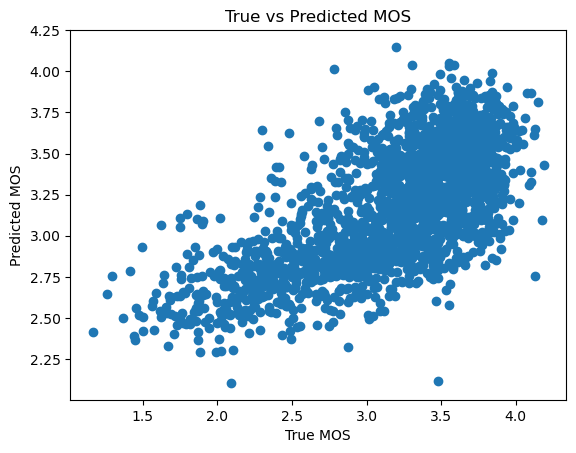

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("True MOS")
plt.ylabel("Predicted MOS")
plt.title("True vs Predicted MOS")
plt.show()


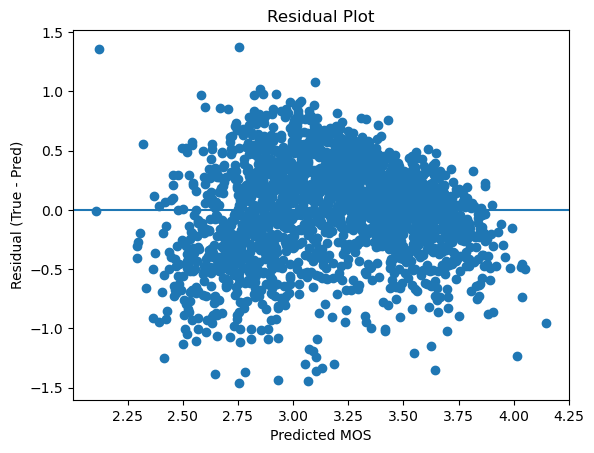

In [21]:
res = y_test - y_pred
plt.figure()
plt.scatter(y_pred, res)
plt.axhline(0)
plt.xlabel("Predicted MOS")
plt.ylabel("Residual (True - Pred)")
plt.title("Residual Plot")
plt.show()


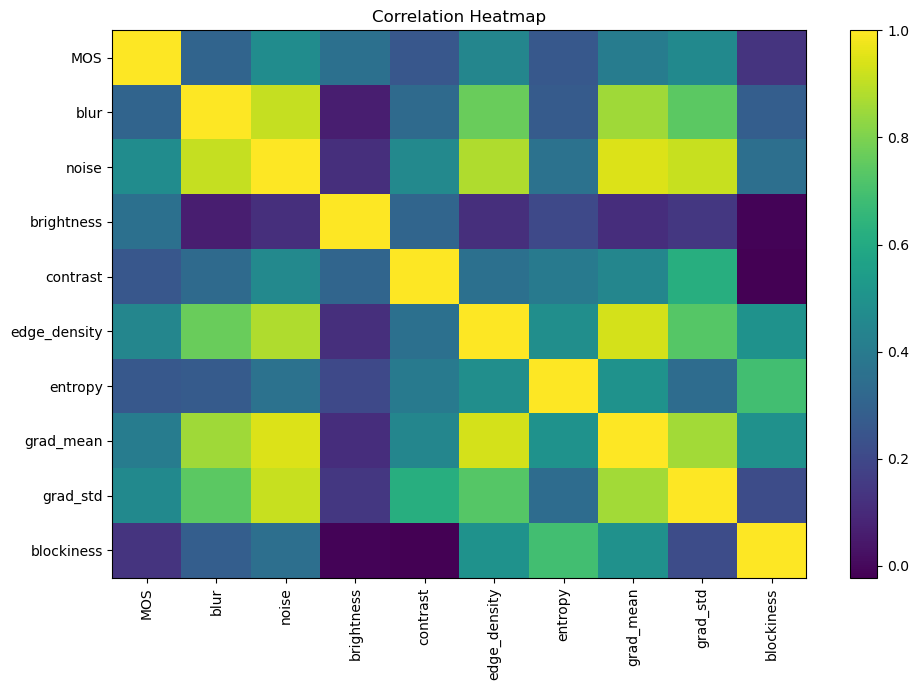

In [22]:
import pandas as pd

corr = features_df.drop(columns=["image_name"]).corr()
plt.figure(figsize=(10,7))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [23]:
coef = model.named_steps["reg"].coef_
imp = pd.Series(coef, index=X.columns).sort_values(key=np.abs, ascending=False)
print(imp)


noise           0.876612
grad_mean      -0.427197
blur           -0.362403
edge_density    0.161678
brightness      0.149287
entropy         0.136146
contrast       -0.104741
blockiness     -0.088259
grad_std       -0.014013
dtype: float64


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np

X = features_df.drop(columns=["image_name","MOS"])
y = features_df["MOS"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

plcc = pearsonr(y_test, y_pred)[0]
srcc = spearmanr(y_test, y_pred)[0]
krcc = kendalltau(y_test, y_pred)[0]

print("RF -> MAE :", mae)
print("RF -> RMSE:", rmse)
print("RF -> R2  :", r2)
print("RF -> PLCC:", plcc)
print("RF -> SRCC:", srcc)
print("RF -> KRCC:", krcc)


RF -> MAE : 0.273245599794985
RF -> RMSE: 0.3546583170741052
RF -> R2  : 0.5996898856750735
RF -> PLCC: 0.7762321095731672
RF -> SRCC: 0.735618735529429
RF -> KRCC: 0.5407399864880987


In [25]:
import pandas as pd

imp_rf = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

imp_rf


blur            0.463965
brightness      0.132719
blockiness      0.074911
contrast        0.068495
grad_mean       0.065984
grad_std        0.051452
edge_density    0.049633
noise           0.047559
entropy         0.045282
dtype: float64

In [26]:
from sklearn.ensemble import RandomForestRegressor
import joblib
import pandas as pd

X = features_df.drop(columns=["image_name","MOS"])
y = features_df["MOS"].astype(float)

rf_final = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X, y)
joblib.dump(rf_final, "rf_mos_model.pkl")
print("Saved: rf_mos_model.pkl")


Saved: rf_mos_model.pkl


In [27]:
imp_final = pd.Series(rf_final.feature_importances_, index=X.columns)\
            .sort_values(ascending=False)
imp_final


blur            0.464028
brightness      0.131960
blockiness      0.076881
contrast        0.067776
grad_mean       0.067198
grad_std        0.050320
edge_density    0.048398
noise           0.048064
entropy         0.045375
dtype: float64

In [28]:
features_df["pred_MOS"] = rf_final.predict(X)

best = features_df.sort_values("pred_MOS", ascending=False).head(10)
best[["image_name","MOS","pred_MOS"]]


,image_name,MOS,pred_MOS
650,121123359.jpg,4.310000,4.064392
5238,5869585652.jpg,4.238095,4.061065
5395,5952914370.jpg,4.130000,4.014448
1250,25239707.jpg,4.147059,3.988176
5988,6285698915.jpg,4.147059,3.987915
671,12949713.jpg,4.153846,3.983257
4634,5466371904.jpg,4.186916,3.982823
4737,5527745877.jpg,4.107143,3.971527
1743,3109733480.jpg,4.122642,3.970264
954,213906996.jpg,4.245283,3.965287


In [29]:
best.iloc[0][["image_name","pred_MOS"]]


image_name    121123359.jpg
pred_MOS           4.064392
Name: 650, dtype: object

In [30]:
t_low  = features_df["pred_MOS"].quantile(0.33)
t_high = features_df["pred_MOS"].quantile(0.66)

print("Reject / Borderline threshold :", t_low)
print("Borderline / Accept threshold :", t_high)


Reject / Borderline threshold : 3.0270599057323175
Borderline / Accept threshold : 3.4533663209670564


In [31]:
def assign_label(v):
    if v >= t_high:
        return "accept"
    elif v < t_low:
        return "reject"
    else:
        return "borderline"

features_df["decision"] = features_df["pred_MOS"].apply(assign_label)

features_df["decision"].value_counts()


decision
accept        3425
borderline    3324
reject        3324
Name: count, dtype: int64

In [32]:
import joblib

# thresholds jo tune nikale the
joblib.dump({
    "model": rf_final,
    "t_low": t_low,
    "t_high": t_high
}, "mos_sort_model.pkl")


['mos_sort_model.pkl']

In [1]:
NEW_IMAGE_DIR = r"C:\Users\lenov\Downloads\test_image_dataset"

In [34]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil
import joblib
from tqdm import tqdm

# ----------------------------
# load trained model + thresholds
# ----------------------------
pack = joblib.load("mos_sort_model.pkl")

model = pack["model"]
t_low = pack["t_low"]
t_high = pack["t_high"]

# ----------------------------
# NEW dataset folder
# ----------------------------
NEW_IMAGE_DIR = r"C:\Users\lenov\Downloads\test_image_dataset"

OUT_BASE = os.path.join(NEW_IMAGE_DIR, "sorted_by_model")

# ----------------------------
# same feature functions
# ----------------------------
def blockiness(gray):
    h, w = gray.shape
    if h < 9 or w < 9:
        return 0.0
    vb = [np.mean(np.abs(gray[:, x] - gray[:, x-1])) for x in range(8, w, 8)]
    hb = [np.mean(np.abs(gray[y, :] - gray[y-1, :])) for y in range(8, h, 8)]
    if (len(vb) + len(hb)) == 0:
        return 0.0
    return float(np.mean(vb + hb))


def extract_features_from_image(img_path):

    img = cv2.imread(img_path)
    if img is None:
        return None

    img = cv2.resize(img, (512, 384))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())

    smooth = cv2.GaussianBlur(gray, (0, 0), 1)
    noise = float(np.std(gray.astype(np.float32) - smooth.astype(np.float32)))

    brightness = float(np.mean(gray))
    contrast   = float(np.std(gray))

    edges = cv2.Canny(gray, 100, 200)
    edge_density = float(np.mean(edges > 0))

    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    p = hist / (hist.sum() + 1e-8)
    entropy = float(-np.sum(p * np.log2(p + 1e-12)))

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, 3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, 3)
    grad = np.sqrt(gx*gx + gy*gy)

    grad_mean = float(np.mean(grad))
    grad_std  = float(np.std(grad))

    blk = blockiness(gray)

    # order must be SAME as training
    return [blur, noise, brightness, contrast,
            edge_density, entropy, grad_mean, grad_std, blk]


# ----------------------------
# collect images
# ----------------------------
img_files = []
for f in os.listdir(NEW_IMAGE_DIR):
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
        img_files.append(f)

print("Total images:", len(img_files))


# ----------------------------
# feature extraction
# ----------------------------
rows = []
valid_names = []

for name in tqdm(img_files):
    p = os.path.join(NEW_IMAGE_DIR, name)
    feats = extract_features_from_image(p)

    if feats is None:
        continue

    rows.append(feats)
    valid_names.append(name)

X_new = pd.DataFrame(
    rows,
    columns=[
        "blur","noise","brightness","contrast",
        "edge_density","entropy","grad_mean","grad_std","blockiness"
    ]
)

# ----------------------------
# predict MOS
# ----------------------------
pred = model.predict(X_new)

df_out = pd.DataFrame({
    "image_name": valid_names,
    "pred_MOS": pred
})


# ----------------------------
# decision using saved thresholds
# ----------------------------
def decide(v):
    if v >= t_high:
        return "accept"
    elif v < t_low:
        return "reject"
    else:
        return "borderline"

df_out["decision"] = df_out["pred_MOS"].apply(decide)


# ----------------------------
# create folders
# ----------------------------
accept_dir = os.path.join(OUT_BASE, "accept")
border_dir = os.path.join(OUT_BASE, "borderline")
reject_dir = os.path.join(OUT_BASE, "reject")

os.makedirs(accept_dir, exist_ok=True)
os.makedirs(border_dir, exist_ok=True)
os.makedirs(reject_dir, exist_ok=True)


# ----------------------------
# copy images
# ----------------------------
cnt = {"accept":0, "borderline":0, "reject":0}

for _, r in df_out.iterrows():

    src = os.path.join(NEW_IMAGE_DIR, r["image_name"])

    if r["decision"] == "accept":
        dst = os.path.join(accept_dir, r["image_name"])
    elif r["decision"] == "borderline":
        dst = os.path.join(border_dir, r["image_name"])
    else:
        dst = os.path.join(reject_dir, r["image_name"])

    shutil.copy2(src, dst)
    cnt[r["decision"]] += 1


print(cnt)

# optional: save report
df_out.to_csv(os.path.join(OUT_BASE, "results.csv"), index=False)
print("Done. Results saved.")


Total images: 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.34it/s]


{'accept': 0, 'borderline': 14, 'reject': 16}
Done. Results saved.


In [2]:
pip install opencv-python scikit-image brisque torch torchvision piq



   ---------------------------------------- 2/2 [brisque]

Note: you may need to restart the kernel to use updated packages.


In [36]:
import cv2
import numpy as np
from brisque import BRISQUE

_brisque = BRISQUE()

def read_image_any(path: str):
    """
    Robust image read for Windows paths (handles some cases where cv2.imread fails).
    Returns BGR image or None.
    """
    try:
        data = np.fromfile(path, dtype=np.uint8)      # works even with weird paths
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)    # decode bytes
        return img
    except Exception:
        return None

def get_brisque_from_path(img_path: str) -> dict:
    img = read_image_any(img_path)
    if img is None:
        return {"path": img_path, "error": "Could not read image"}

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    score = float(_brisque.score(img_rgb))  # lower = better
    return {"path": img_path, "brisque": score}


In [37]:
def decide_brisque(brisque: float) -> str:
    if brisque <= 30:
        return "accept"
    elif brisque <= 45:
        return "borderline"
    else:
        return "reject"


In [38]:
import os
import cv2
import numpy as np
from brisque import BRISQUE

# -------- find 512x384 folder automatically --------
ROOT = r"C:\Users\lenov"
TARGET = None

for root, dirs, files in os.walk(ROOT):
    if os.path.basename(root) == "512x384":
        TARGET = root
        break

print("Found folder:", TARGET)

if TARGET is None:
    raise RuntimeError("512x384 folder not found")

# -------- robust image read --------
def read_image_any(path):
    data = np.fromfile(path, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_COLOR)

# -------- BRISQUE only --------
_brisque = BRISQUE()

def get_brisque_from_path(p):
    img = read_image_any(p)
    if img is None:
        return None
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return float(_brisque.score(rgb))


IMG_EXT = (".jpg",".jpeg",".png",".bmp",".webp")
files = [f for f in os.listdir(TARGET) if f.lower().endswith(IMG_EXT)]

print("Total images:", len(files))

# try first readable image
for f in files[:200]:
    p = os.path.join(TARGET, f)
    s = get_brisque_from_path(p)
    if s is not None:
        print("Image:", p)
        print("BRISQUE:", s)
        break


Found folder: C:\Users\lenov\image_quality_assesment\archive\512x384
Total images: 10373
Image: C:\Users\lenov\image_quality_assesment\archive\512x384\10004473376.jpg
BRISQUE: 9.756527017030947


In [39]:
def get_brisque_from_path(p):
    ...
    return float(_brisque.score(rgb))
def extract_brisque_feature(img_path):
    s = get_brisque_from_path(img_path)
    if s is None:
        return np.nan   # ya koi default like 50
    return s


In [40]:
def extract_features(img_path):
    f1 = blur(img_path)
    f2 = contrast(img_path)
    f3 = brightness(img_path)

    bq = extract_brisque_feature(img_path)

    return [f1, f2, f3, bq]


In [41]:
def decide_by_brisque(b):
    if b <= 30:
        return "accept"
    elif b <= 45:
        return "borderline"
    else:
        return "reject"


In [42]:
import regression
print("regression imported OK")


regression imported OK


In [49]:
pip install streamlit opencv-python numpy brisque


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!streamlit run ui.py
